In [2]:
#Utils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from tqdm import tqdm

#NLP
import nltk
from nltk import sent_tokenize, word_tokenize, RegexpParser
from nltk.sentiment.util import mark_negation
from nltk.corpus import stopwords, wordnet
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tag import pos_tag

#Machine Learning
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

#WordCloud
from wordcloud import WordCloud

#Radar Chart
import plotly.express as px
from plotly.offline import download_plotlyjs, init_notebook_mode,  plot

In [3]:
#Download resource
nltk.download("stopwords")
nltk.download("punkt")
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('words')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [4]:
"""
        Preprocessing text for TfidfVectorizer
          - remove non-character
          - tokenization
          - stopword removal
          - lemmatization
        Parameters
        ----------
        reviews : list
             reviews of customer in hospital
        Return
        ----------
        cleaned_reviews : list
             Preprocessed Reviews  
"""
def preprocess_review(reviews): 
    cleaned_reviews = []
    for review in reviews:
        review = re.sub("[^a-zA-Z]", " ", review)
        words = word_tokenize(review) 
        tokenized_words = [word.lower() for word in words if word not in stopwords.words("english")]
        lemmatized_word = lemmatize_word(tokenized_words)
        cleaned_reviews.append(lemmatized_word)
    return cleaned_reviews

In [5]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return 'a'

In [6]:
def lemmatize_word(tokenized_words): 
    lemmatizer = WordNetLemmatizer() 
    lemmatized_words = []
    for word, tag in pos_tag(tokenized_words):
        pos = get_wordnet_pos(tag)
        lemmatized_words.append(lemmatizer.lemmatize(word, pos))
    lemmatized_words = ' '.join([str(word) for word in lemmatized_words]) 
    return lemmatized_words

In [7]:
def extract_sentences(df):
  sentences = []
  scores = [] 
  cids = [] 
  for cid in df["cid"]:
    en = df.loc[cid, "review"]
    score = df.loc[cid, "rating"]
    s = sent_tokenize(en)
    sentences = sentences + s
    scores = scores + [score]*len(s)
    cids = cids + [cid] * len(s) 
  return pd.DataFrame({"reviews": sentences, "ratings": scores, "cids": cids})

In [8]:
def train_multinomial_nb(X_train, X_test, y_train, y_test):
     
    tfidf_vectorizer = TfidfVectorizer()
    multinomial_nb_clf = MultinomialNB()
    multinomial_naive_bayes_pipeline = Pipeline([
            ('tfidf', tfidf_vectorizer),
            ('classifier', multinomial_nb_clf)
    ])
    multinomial_naive_bayes_params = {}
    grid = GridSearchCV(multinomial_naive_bayes_pipeline, param_grid = multinomial_naive_bayes_params, cv = 10, scoring = 'roc_auc')
    grid.fit(X_train, y_train)
     
    print("Best Score : %.2f" %  grid.best_score_)
    print("Best Params : ")
    print(grid.best_params_)
    
    y_pred = grid.predict(X_test)
    print("Accuracy : %.2f" % accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    return grid.best_estimator_

In [9]:
def train_random_forest(X_train, X_test, y_train, y_test):
    
    tfidf_vectorizer = TfidfVectorizer()
    rf_clf =  RandomForestClassifier(random_state=2020, class_weight="balanced")
    rf_pipeline = Pipeline([
            ('tfidf', tfidf_vectorizer),
            ('classifier', rf_clf)
    ])
    rf_params = {
        "classifier__n_estimators": range(50, 200, 50),
        "classifier__max_depth": range(2, 10, 2), 
        "classifier__min_samples_leaf": range(1, 4)
    }
    grid = GridSearchCV(rf_pipeline, param_grid=rf_params, cv=10, scoring='roc_auc')
    grid.fit(X_train, y_train) 
    
    print("Best Score : %.2f" %  grid.best_score_)
    print("Best Params : ")
    print(grid.best_params_)
    
    y_pred = grid.predict(X_test)
    print("Accuracy : %.2f" % accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    return grid.best_estimator_

In [10]:
def train_svm(X_train, X_test, y_train, y_test):
     
    tfidf_vectorizer = TfidfVectorizer()
    svm_clf =  SVC(random_state=2020, class_weight="balanced", probability=True)
    svm_pipeline = Pipeline([
            ('tfidf', tfidf_vectorizer),
            ('classifier', svm_clf)
    ])
    svm_params = {
        "classifier__C": [ 0.1, 0.5, 1, 5, 10 ],
        "classifier__gamma": np.arange(0.1,1,0.1)
    }
    grid = GridSearchCV(svm_pipeline, param_grid=svm_params, cv=10, scoring='roc_auc')
    grid.fit(X_train, y_train) 
    
    print("Best Score : %.2f" %  grid.best_score_)
    print("Best Params : ")
    print(grid.best_params_)
    
    y_pred = grid.predict(X_test)
    print("Accuracy : %.2f" % accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    return grid.best_estimator_

In [11]:
def predict_sentiment(estimator, df):
  sentiments = []
  for sentence in df["reviews"]: 
    sentiment = estimator.predict([sentence])
    if sentiment == 1:
      sentiment = "positive"
    else:
      sentiment = "negative"
    sentiments.append( sentiment ) 
  return sentiments

In [51]:
def plural2singular(word):
  if word == "doctors":
    return "doctor"
  elif word == "nurses":
    return "nurse"
  elif word == "clinics":
    return "clinic"
  elif word == "hospitals":
    return "hospital"
  elif word == "services":
    return "service"
  elif word == "staffs":
    return "staff"
  elif word == "treatments":
    return "treatment"
  elif word == "students":
    return "student"
  else:
    return word

In [52]:
def create_parsed_trees(df):
  grammar = """NP: {<NN|NNS>+}
                 {<NN|NNS>+<CC><NN|NNS>+}"""
  chunker = RegexpParser(grammar)
  parse_trees = []
  for sentence in df['reviews']:
      parse_trees.append(chunker.parse(pos_tag(word_tokenize(sentence))))
  return parse_trees

In [53]:
def extract_noun_phrases(parsed_trees):
    nps = []
    for parsed_tree in parsed_trees:
      np = []
      for subtree in parsed_tree.subtrees():
          if subtree.label() == 'NP':
              t = subtree
              t = " ".join(word for word, tag in t.leaves())
              np.append(t)
      nps.append(np)
    return nps

In [54]:
def vizwordcloud(df, colormap = 'viridis'):
    tuples = [tuple(x) for x in df.values]
    wordcloud = WordCloud(width=1000,height=800,colormap=colormap,max_words=100).generate_from_frequencies(dict(tuples))
    plt.figure(figsize=(20,10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [57]:
def get_data_for_wordcloud(df, sentiment):
  sentiment_only = df[df["sentiments"] == sentiment].reset_index(drop=True)
  words = sum(sentiment_only["NP"].tolist(), [])
  words = [word.lower() for word in words]
  words = [plural2singular(word) for word in words]
  hist = pd.DataFrame({"words": words})
  short_sentiment = sentiment[0:3]
  hist = hist.groupby("words").size().reset_index(name="#"+short_sentiment)
  return hist

# Model Training

In [58]:
train_test_data = pd.read_csv("train_test_data.csv", index_col=False, header = 0, names = ['review_th', 'rating', 'review'])
train_test_data = train_test_data.reset_index()
train_test_data = train_test_data.rename(columns={"index": "cid"})
train_test_data = extract_sentences(train_test_data) 
train_test_data["cleaned_reviews"] = preprocess_review(train_test_data["reviews"])

In [59]:
X = train_test_data["cleaned_reviews"]
y = train_test_data["ratings"]

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 2020)

**Multinomial Naive Bayes**

In [61]:
multinomial_nb_classifier = train_multinomial_nb(X_train, X_test, y_train, y_test)

Best Score : 0.79
Best Params : 
{}
Accuracy : 0.76
              precision    recall  f1-score   support

           0       0.77      0.75      0.76       409
           1       0.74      0.77      0.75       381

   micro avg       0.76      0.76      0.76       790
   macro avg       0.76      0.76      0.76       790
weighted avg       0.76      0.76      0.76       790



**Random Forest**

In [63]:
random_forest_classifier = train_random_forest(X_train, X_test, y_train, y_test)

Best Score : 0.77
Best Params : 
{'classifier__max_depth': 8, 'classifier__min_samples_leaf': 1, 'classifier__n_estimators': 100}
Accuracy : 0.69
              precision    recall  f1-score   support

           0       0.66      0.83      0.74       409
           1       0.75      0.54      0.62       381

   micro avg       0.69      0.69      0.69       790
   macro avg       0.70      0.68      0.68       790
weighted avg       0.70      0.69      0.68       790



**Support Vector Machine**

In [64]:
svm_classifier = train_svm(X_train, X_test, y_train, y_test)

Best Score : 0.78
Best Params : 
{'classifier__C': 1, 'classifier__gamma': 0.2}
Accuracy : 0.73
              precision    recall  f1-score   support

           0       0.70      0.85      0.77       409
           1       0.79      0.61      0.69       381

   micro avg       0.73      0.73      0.73       790
   macro avg       0.74      0.73      0.73       790
weighted avg       0.74      0.73      0.73       790



# Bumrungrad Hospital

In [65]:
bumrungrad = pd.read_csv("bumrungrad-translated.csv", index_col=False, header = 0, names = ['review_th', 'rating', 'review'])
bumrungrad = bumrungrad.reset_index()
bumrungrad = bumrungrad.rename(columns={"index": "cid"})
bumrungrad = extract_sentences(bumrungrad) 
bumrungrad["cleaned_reviews"] = preprocess_review(bumrungrad["reviews"])

In [66]:
bumrungrad["sentiments"] = predict_sentiment(multinomial_nb_classifier, bumrungrad)

In [67]:
bumrungrad["NP"] = extract_noun_phrases(create_parsed_trees(bumrungrad))

In [68]:
bumrungrad

,reviews,ratings,cids,cleaned_reviews,sentiments,NP
0,Hospitals are very well behaved.,1,0,hospital well behave,positive,[Hospitals]
1,There's a very good doctor patient.,1,0,there good doctor patient,positive,[doctor patient]
2,"Nurses do not bother me face cafeteria clean, ...",1,0,nurse bother face cafeteria clean good front i...,positive,"[Nurses, clean, front, diameter]"
3,The Banco vaccine and the detection of allergi...,1,0,the banco vaccine detection allergy child,positive,"[vaccine, detection, allergies, children]"
4,This treatment is here The X-ray machines thro...,1,0,this treatment the x ray machine modern expert...,positive,"[treatment, machines, Experts, boy, food]"
5,Nursing bright toys those children,1,0,nursing bright toy child,negative,"[toys, children]"
6,I gained knowledge from this article very much.,1,1,i gain knowledge article much,positive,"[knowledge, article]"
7,And can be applied in everyday life.,1,1,and apply everyday life,positive,[life]
8,It may fit all ages.,1,1,it may fit age,positive,[ages]
9,"In the article, readers can understand easily.",1,1,in article reader understand easily,positive,"[article, readers]"


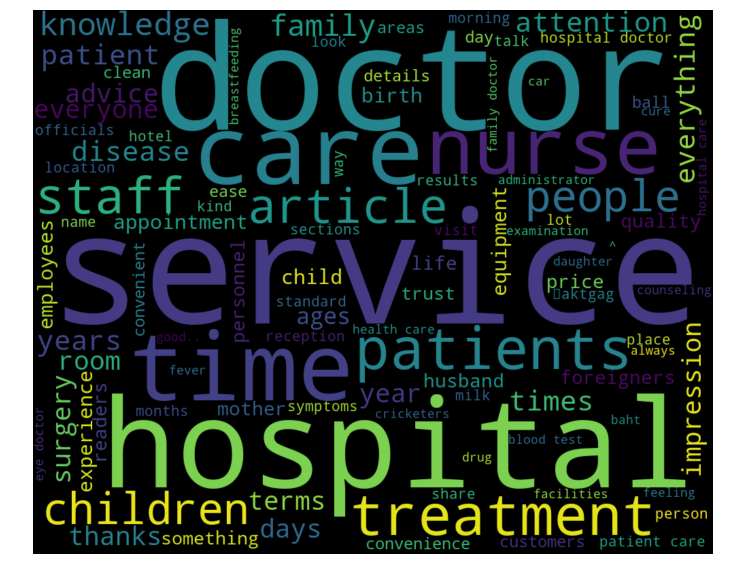

In [69]:
bumrungrad_positive = get_data_for_wordcloud(bumrungrad, "positive")
vizwordcloud(bumrungrad_positive)

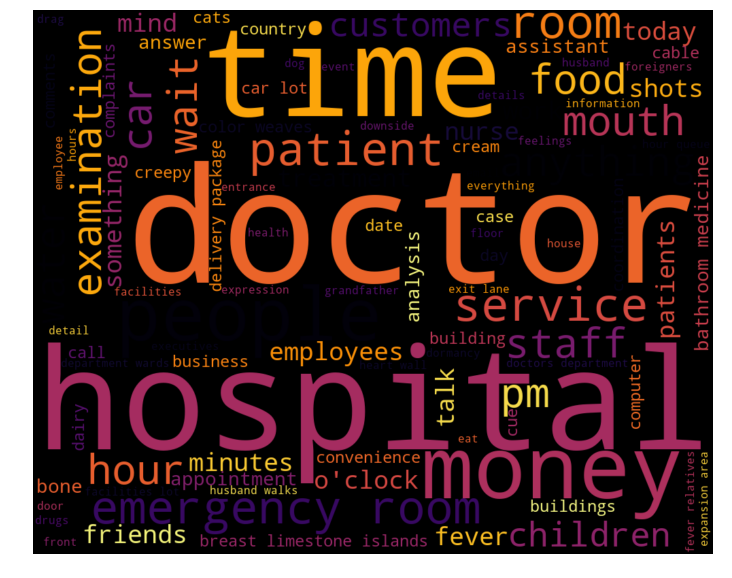

In [70]:
bumrungrad_negative = get_data_for_wordcloud(bumrungrad, "negative")
vizwordcloud(bumrungrad_negative, "inferno")

# Lerdsin Hospital

In [71]:
lerdsin = pd.read_csv("lerdsin-translated.csv", index_col=False, header = 0, names = ['review_th', 'rating', 'review'])
lerdsin = lerdsin.reset_index()
lerdsin = lerdsin.rename(columns={"index": "cid"})
lerdsin = extract_sentences(lerdsin) 
lerdsin["cleaned_reviews"] = preprocess_review(lerdsin["reviews"])

In [72]:
lerdsin["sentiments"] = predict_sentiment(multinomial_nb_classifier, lerdsin)

In [73]:
lerdsin["NP"] = extract_noun_phrases(create_parsed_trees(lerdsin))

In [74]:
lerdsin

,reviews,ratings,cids,cleaned_reviews,sentiments,NP
0,I can't remember which year it was at the end ...,1,0,i remember year end year,positive,"[year, end, year]"
1,At that time we were hemorrhoids.,1,0,at time hemorrhoid,negative,"[time, hemorrhoids]"
2,Do not dare to see a doctor because of fear of...,1,0,do dare see doctor fear treatment hurt and emb...,positive,"[doctor, fear, treatment, butt, others, person..."
3,Looking at our trembling fears when knowing th...,1,0,look tremble fear know need commit read inform...,positive,"[fears, information, web, treatment]"
4,He said it was a lethal disease.,1,0,he say lethal disease,positive,[disease]
5,Is a disease that many people have If the lump...,1,0,be disease many people if lump inside rubber b...,positive,"[disease, people, lump, inside, rubber band, f..."
6,We are external.,1,0,we external,positive,[]
7,"I read that I was going to have anesthesia, an...",1,0,i read i go anesthesia anesthetize even though...,positive,"[anesthesia, anesthetize, doctor, butt]"
8,Knowledge of when cutting a knife May not hurt...,1,0,knowledge cut knife may hurt hurt little but f...,positive,"[knife, feeling, treatment, feeling, fear]"
9,The doctor would probably catch even though we...,1,0,the doctor would probably catch even though so...,positive,"[doctor, security card]"


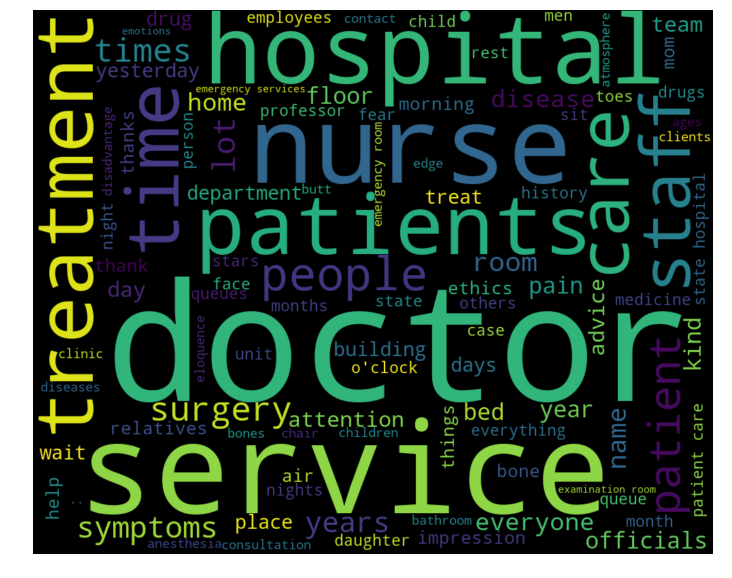

In [75]:
lerdsin_positive = get_data_for_wordcloud(lerdsin, "positive")
vizwordcloud(lerdsin_positive)

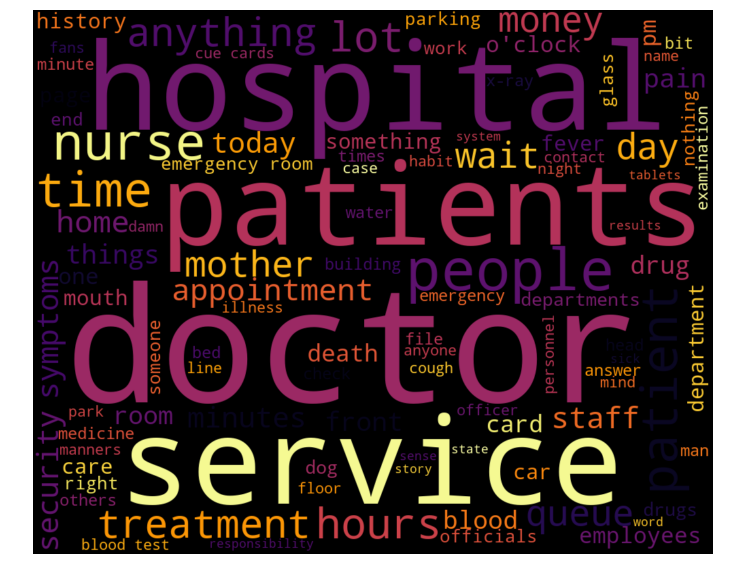

In [76]:
lerdsin_negative = get_data_for_wordcloud(lerdsin, "negative")
vizwordcloud(lerdsin_negative, "inferno")

# Rajavithi Hospital

In [77]:
rajavithi = pd.read_csv("rajavithi-translated.csv", index_col=False, header = 0, names = ['review_th', 'rating', 'review'])
rajavithi = rajavithi.reset_index()
rajavithi = rajavithi.rename(columns={"index": "cid"})
rajavithi = extract_sentences(rajavithi) 
rajavithi["cleaned_reviews"] = preprocess_review(rajavithi["reviews"])

In [78]:
rajavithi["sentiments"] = predict_sentiment(multinomial_nb_classifier, rajavithi)

In [79]:
rajavithi["NP"] = extract_noun_phrases(create_parsed_trees(rajavithi))

In [80]:
rajavithi

,reviews,ratings,cids,cleaned_reviews,sentiments,NP
0,Hospital beautiful atmosphere with cool air.,1,0,hospital beautiful atmosphere cool air,positive,"[beautiful, air]"
1,To ease Hospital staffs all very nice to me si...,1,0,to ease hospital staff nice since,positive,[staffs]
2,It is recommended that people wait to fill out...,1,0,it recommend people wait fill new patient i know,negative,"[people, patient]"
3,What to do in the next step.,1,0,what next step,negative,[step]
4,Which floor to go to the doctor As I reached t...,1,0,which floor go doctor as i reach front check wait,negative,"[floor, doctor, front, check]"
5,Nurses and doctors generous The treatment is e...,1,0,nurse doctor generous the treatment expensive ...,positive,"[Nurses, doctors, treatment]"
6,Center Specialty Hospital is very good.,1,1,center specialty hospital good,positive,[]
7,You are all very kind and very good mentor is ...,1,1,you kind good mentor great keep warm nurse lovely,positive,"[kind, mentor, nurse]"
8,You have to go a bit to get to the queue.,1,1,you go bit get queue,negative,"[bit, queue]"
9,"Of medicine at the hospital, it is very inexpe...",1,1,of medicine hospital inexpensive easily access...,positive,"[medicine, hospital]"


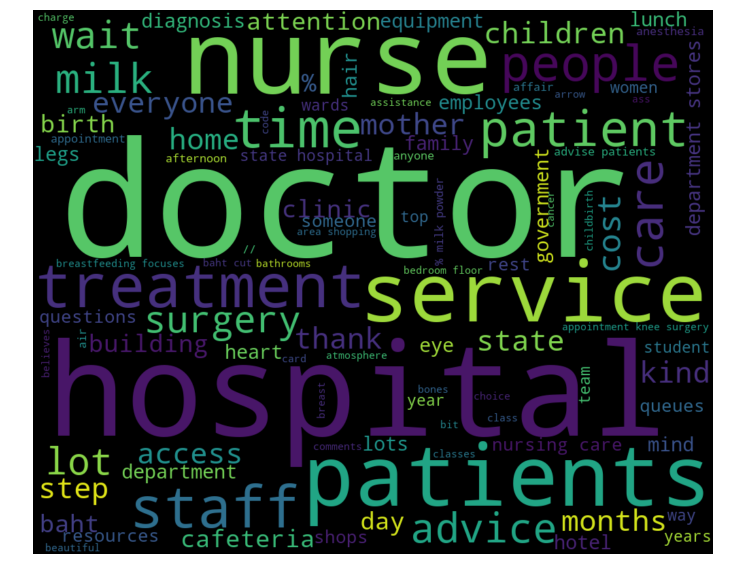

In [81]:
rajavithi_positive = get_data_for_wordcloud(rajavithi, "positive")
vizwordcloud(rajavithi_positive)

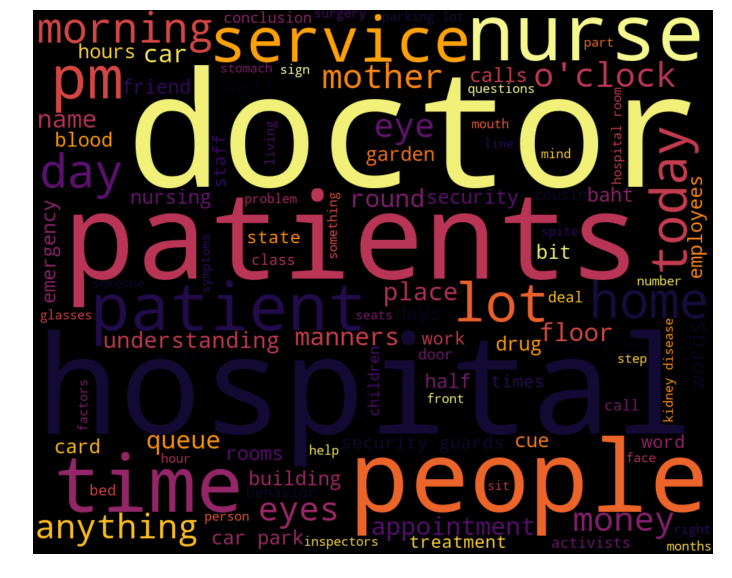

In [82]:
rajavithi_negative = get_data_for_wordcloud(rajavithi, "negative")
vizwordcloud(rajavithi_negative, "inferno")

# Radar Chart 

In [83]:
def groups(word):
    if word in ("doctor", "nurse", "student", "security guard"):
        return "staff"
    elif word in ("hospital", "clinic", "equipment", "place","building","room"):
        return "infrastructure"
    elif word in ("care", "treatment", "advice", "surgery", "disease", "medical care", "service", "responsibility","manner","talking" ):
        return "service"
    elif word in ("queue", "appointment","process", "management"):
        return "process"
    elif word in ("price", "claim"):
        return "finance"
    else:
        return "others"

In [84]:
def  catagory_pos(pos_df): 
    pos_df["category"] = pos_df["words"].apply(lambda x: groups(x))
    hos_poscount = pos_df.groupby("category").size().reset_index(name="#")
    hos_poscount = hos_poscount[hos_poscount["category"] != "others"].reset_index(drop=True)
    return hos_poscount

In [85]:
def  catagory_neg(neg_df): 
    neg_df ["category"] = neg_df["words"].apply(lambda x: groups(x))
    hos_negcount = neg_df.groupby("category").size().reset_index(name="#")
    hos_negcount =  hos_negcount[ hos_negcount["category"] != "others"].reset_index(drop=True)
    return hos_negcount 

In [86]:
#poscount
bumrungrad_poscount = catagory_pos(bumrungrad_positive)
rajavithi_poscount = catagory_pos(rajavithi_positive)
lerdsin_poscount = catagory_pos(lerdsin_positive)

In [87]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatterpolar(
      r=bumrungrad_poscount["#"],
      theta= bumrungrad_poscount['category'],
      fill='toself',
      name='bumrungrad_positive'
))
fig.add_trace(go.Scatterpolar(
      r= rajavithi_poscount["#"],
      theta= rajavithi_poscount['category'],
      fill='toself',
      name='rajavithi_positive'
))
fig.add_trace(go.Scatterpolar(
      r= lerdsin_poscount["#"],
      theta=lerdsin_poscount['category'],
      fill='toself',
      name='lerdsin_positive'
))
fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 6]
    )),
  showlegend=True
)
fig.show()

In [88]:
#negcount
bumrungrad_negcount = catagory_neg(bumrungrad_negative)
rajavithi_negcount = catagory_neg(rajavithi_negative)
lerdsin_negcount = catagory_neg(lerdsin_negative)

In [89]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatterpolar(
      r=bumrungrad_negcount["#"],
      theta= bumrungrad_negcount['category'],
      fill='toself',
      name='bumrungrad_negative'
))
fig.add_trace(go.Scatterpolar(
      r= rajavithi_negcount["#"],
      theta= rajavithi_negcount['category'],
      fill='toself',
      name='rajavithi_negative'
))
fig.add_trace(go.Scatterpolar(
      r= lerdsin_negcount["#"],
      theta=lerdsin_negcount['category'],
      fill='toself',
      name='lerdsin_negative'
))
fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 6]
    )),
  showlegend=True
)
fig.show()